In [101]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3
import os
os.chdir(os.path.expanduser('~/wcEcoli'))
import numpy as np
import pandas as pd
from wholecell.utils.filepath import ROOT_PATH
import pickle
import os
from matplotlib import pyplot as plt
# noinspection PyUnresolvedReferences
from wholecell.io.tablereader import TableReader
import io
from wholecell.io import tsv
from wholecell.utils.filepath import ROOT_PATH
import plotly.graph_objects as go
from models.ecoli.analysis import cohortAnalysisPlot
from wholecell.analysis.analysis_tools import (exportFigure,
	read_bulk_molecule_counts, read_stacked_bulk_molecules, read_stacked_columns)
from wholecell.io.tablereader import TableReader
from sklearn.metrics import r2_score
import seaborn as sns
import glob
import plotly.express as px

In [102]:
# generate a dataframe with relevant information:
# Name the sequences to use:
current_sequence = "Clim4_STD_ratio_threshold_2_keep_NaNs"
CLNE_sequence = "CLNE4"
branch_name = "pd-half-life-debug"

In [103]:
# Read in the half life data from the output of models/ecoli/analysis/parca/protein_half_lives.py:
clim_df = f"out/{current_sequence}/kb_plot_out/protein_half_lives.tsv"
clim_df = pd.read_csv(clim_df, sep='\t')

# Load in the log average counts data generated from the output of cohort/save_cohort_average_monomer_counts.py:
clim_log_data = pd.read_csv(f'out/{current_sequence}/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')
CLNE_log_data = pd.read_csv(f'out/{CLNE_sequence}/wildtype_000000/cohort_average_monomer_count_data/unfiltered_data/log_data/LogAvgProteinCounts_startGen_2.csv')

# Remove the last three characters from each entry in the Monomer ID column:
clim_log_data['Monomer ID'] = clim_log_data['Monomer ID'].str[:-3]
CLNE_log_data['Monomer ID'] = CLNE_log_data['Monomer ID'].str[:-3]

# rename the Log10 Average Monomer Counts column to include the sequence name:
CLNE_new_name = "Log10 " + CLNE_sequence +" Average Monomer Counts"
CLClimNE_new_name = "Log10 " +current_sequence +" Average Monomer Counts"
clim_log_data = clim_log_data.rename(columns={"Log10 Average Monomer Counts": CLClimNE_new_name})
CLNE_log_data = CLNE_log_data.rename(columns={"Log10 Average Monomer Counts": CLNE_new_name})

# Merge the long dataframes together:
clim_log_data = clim_log_data.set_index("Monomer ID")
CLNE_log_data = CLNE_log_data.set_index("Monomer ID")
combined_log_data = CLNE_log_data.join(clim_log_data, how="inner")
combined_log_data = combined_log_data.reset_index()

# Merge this data with the clim_df to get the protease assignments:
combined_log_data = combined_log_data.rename(columns={"Monomer ID": "monomer_id"})
clim_df = clim_df.merge(combined_log_data, on='monomer_id', how='left')
clim_df = clim_df.rename(columns={"degradation_rate_source": "half_life_source"})

# calculate the fold change between the log counts of CLNE and CLClim3NE:
clim_df['protein_fold_change'] = 10**(clim_df[CLClimNE_new_name]) / 10**(clim_df[CLNE_new_name])
# calculate the log2 fold change between the log counts of CLNE and CLClim3NE:
clim_df['log2_fold_change'] = np.log2(clim_df['protein_fold_change'])
# calculate the log10 fold change between the log counts of CLNE and CLClim3NE:
clim_df['log10_fold_change'] = np.log10(clim_df['protein_fold_change'])


clim_df

,monomer_id,common_name,degradation_rate(1/s),half_life_(min),half_life_source,protease_assignment,ClpP_fraction,Lon_fraction,HslV_fraction,Log10 CLNE4 Average Monomer Counts,Log10 Clim4_STD_ratio_threshold_2_keep_NaNs Average Monomer Counts,protein_fold_change,log2_fold_change,log10_fold_change
0,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-MONOMER,plsC,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,2.268022,2.251999,0.963779,-0.053226,-0.016023
1,1-PFK-MONOMER,fruK,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,2.122165,1.916220,0.622379,-0.684134,-0.205945
2,2-DEHYDROPANTOATE-REDUCT-MONOMER,panE,0.000027,432.820802,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,2.408375,2.235185,0.671135,-0.575324,-0.173190
3,2-ISOPROPYLMALATESYN-MONOMER,leuA,0.000021,545.536619,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,3.617142,3.563799,0.884417,-0.177202,-0.053343
4,2-OCTAPRENYL-METHOXY-BENZOQ-METH-MONOMER,ubiE,0.000009,1343.256864,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,2.612021,2.554319,0.875585,-0.191680,-0.057702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4304,YTFR-MONOMER,ytfR,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,1.545795,1.581673,1.086121,0.119185,0.035878
4305,YTFT-MONOMER,ytfT,0.000006,2083.445324,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,1.536472,1.553161,1.039174,0.055437,0.016688
4306,ZNUA-MONOMER,znuA,0.000005,2225.002167,Gupta_et_al_MS_2024,NaN,NaN,NaN,NaN,2.808006,2.851287,1.104793,0.143776,0.043281
4307,ZNUB-MONOMER,znuB,0.000019,600.000000,N_end_rule,NaN,NaN,NaN,NaN,1.860300,1.795018,0.860436,-0.216861,-0.065282


In [104]:
# count the number of different assignements in the protease_assignment column and how many times they appear
counts = clim_df['protease_assignment'].value_counts()
counts = counts.to_dict()
counts

{'ClpP only': 40,
 'Additive: ClpP, Lon, HslV': 32,
 'Lon only': 6,
 'Additive: ClpP, Lon': 3,
 'HslV only': 1}

# Donut plot

Code adapted from: https://python-graph-gallery.com/donut-plot/

Pros: easy to see

Cons: cannot put the #s on the chart itself, which might be nice (could just add it as brackets tho

Future things to explore: maybe split up more, into having a each pie slice have a lighter shade in it to represent monomers vs the darker shade representing complexes.

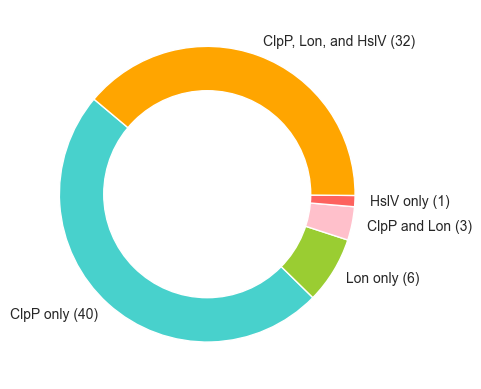

In [105]:

size_of_groups=[40, 6, 3, 1, 32]
# create data
names = ['ClpP only (40)', 'Lon only (6)', 'ClpP and Lon (3)', 'HslV only (1)', 'ClpP, Lon, and HslV (32)']
colors = ['mediumturquoise','yellowgreen','pink','#fd625e', 'orange']
# Create a pieplot
plt.pie(size_of_groups, labels=names, colors=colors, startangle=140,  )

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')

p=plt.gcf()
p.gca().add_artist(my_circle)

plt.show()


# priority substrate data plots

# prep data

In [106]:
clim_combined_df = clim_df.copy()

# figure out which proteins were assigned to lon in the model:
lon_proteins = clim_combined_df[clim_combined_df['protease_assignment'] == 'Lon only']

# figure out which proteins were assigned to clp in the model:
clp_proteins = clim_combined_df[clim_combined_df['protease_assignment'] == 'ClpP only']

hslv_proteins = clim_combined_df[clim_combined_df['protease_assignment'] == 'HslV only']

# figure out which proteins are additive in the model:
additive_proteins = clim_combined_df[clim_combined_df['protease_assignment'] == 'Additive: ClpP, Lon']

# figure out which proteins are redundant in the model:
redundant_proteins = clim_combined_df[clim_combined_df['protease_assignment'] == 'Additive: ClpP, Lon, HslV']

# figure out which proteins were not assigned to a protease in the model:
no_protease_proteins = clim_combined_df[clim_combined_df['protease_assignment'] == 'NA']

# todo: note that these numbers will not add up to those in the graph below bc some proteins in the 2025 model are not in the 2020 model
#298 total
print("Lon Proteins(" +str(len(lon_proteins))+"): ", list(lon_proteins['common_name'])) #14
print("ClpP Proteins(" +str(len(clp_proteins))+"): ", list(clp_proteins['common_name'])) #63
print("HslV Proteins(" +str(len(hslv_proteins))+"): ", list(hslv_proteins['common_name'])) #1
print("Additive Proteins: Lon, ClpP (" +str(len(additive_proteins))+"): ", list(additive_proteins['common_name'])) #79
print("Additive: Lon, ClpP, HslV Proteins(" +str(len(redundant_proteins))+"): ", list(redundant_proteins['common_name'])) 

Lon Proteins(6):  ['ydcI', 'nemA', 'fhlA', 'metR', 'trxC', 'rpoD']
ClpP Proteins(40):  ['fadE', 'glpD', 'cysD', 'ribB', 'clpA', 'clpX', 'dksA', 'dnaB', 'dnaK', 'ftsZ', 'mukB', 'mutS', 'nfo', 'parC', 'pcnB', 'recA', 'rpsA', 'sbcC', 'uvrD', 'dps', 'def', 'phoH', 'intA', 'rutA', 'comR', 'ydhQ', 'yfcZ', 'patA', 'obgE', 'yheO', 'lldD', 'mdlB', 'oxyR', 'exuR', 'putA', 'rpoB', 'rpoC', 'rpoS', 'yheS', 'znuC']
HslV Proteins(1):  ['uhpA']
Additive Proteins: Lon, ClpP (3):  ['ibpA', 'grcA', 'dnaA']
Additive: Lon, ClpP, HslV Proteins(32):  ['aroK', 'helD', 'ligA', 'minE', 'parE', 'pspA', 'rhlB', 'srmB', 'ybaB', 'yibA', 'mazF', 'yjgA', 'yihD', 'yiiQ', 'yiaU', 'yfhH', 'erpA', 'ppiC', 'glaR', 'chaB', 'rarA', 'proQ', 'acpP', 'ycaR', 'hprR', 'murQ', 'iscR', 'kbp', 'yggX', 'glnD', 'yaeP', 'thiL']


In [107]:
# prepare the data for a plot:
CLNE_CLClimNE_log_data_proteases = clim_combined_df.copy()

# make a copy of the CLClimNE_log_data_with_proteases data:
CLClimNE_log_data_with_Lon_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Clp_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_HslV_proteases = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Additive_LC = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_Additive_LCH = CLNE_CLClimNE_log_data_proteases.copy()
CLClimNE_log_data_with_no_protease_proteases = CLNE_CLClimNE_log_data_proteases.copy()

# remove the proteins that were not assigned to the protease in the model:
CLClimNE_log_data_with_Lon_proteases = CLClimNE_log_data_with_Lon_proteases[CLClimNE_log_data_with_Lon_proteases['protease_assignment'] == 'Lon only']
CLClimNE_log_data_with_Clp_proteases = CLClimNE_log_data_with_Clp_proteases[CLClimNE_log_data_with_Clp_proteases['protease_assignment'] == 'ClpP only']
CLClimNE_log_data_with_HslV_proteases = CLClimNE_log_data_with_HslV_proteases[CLClimNE_log_data_with_HslV_proteases['protease_assignment'] == 'HslV only']
CLClimNE_log_data_with_Additive_LC_proteases = CLClimNE_log_data_with_Additive_LC[CLClimNE_log_data_with_Additive_LC['protease_assignment'] == 'Additive: ClpP, Lon']
CLClimNE_log_data_with_Additive_LCH_proteases = CLClimNE_log_data_with_Additive_LCH[CLClimNE_log_data_with_Additive_LCH['protease_assignment'] == 'Additive: ClpP, Lon, HslV']
CLClimNE_log_data_with_no_protease_proteases = CLClimNE_log_data_with_no_protease_proteases[CLClimNE_log_data_with_no_protease_proteases['protease_assignment'] == 'NA']


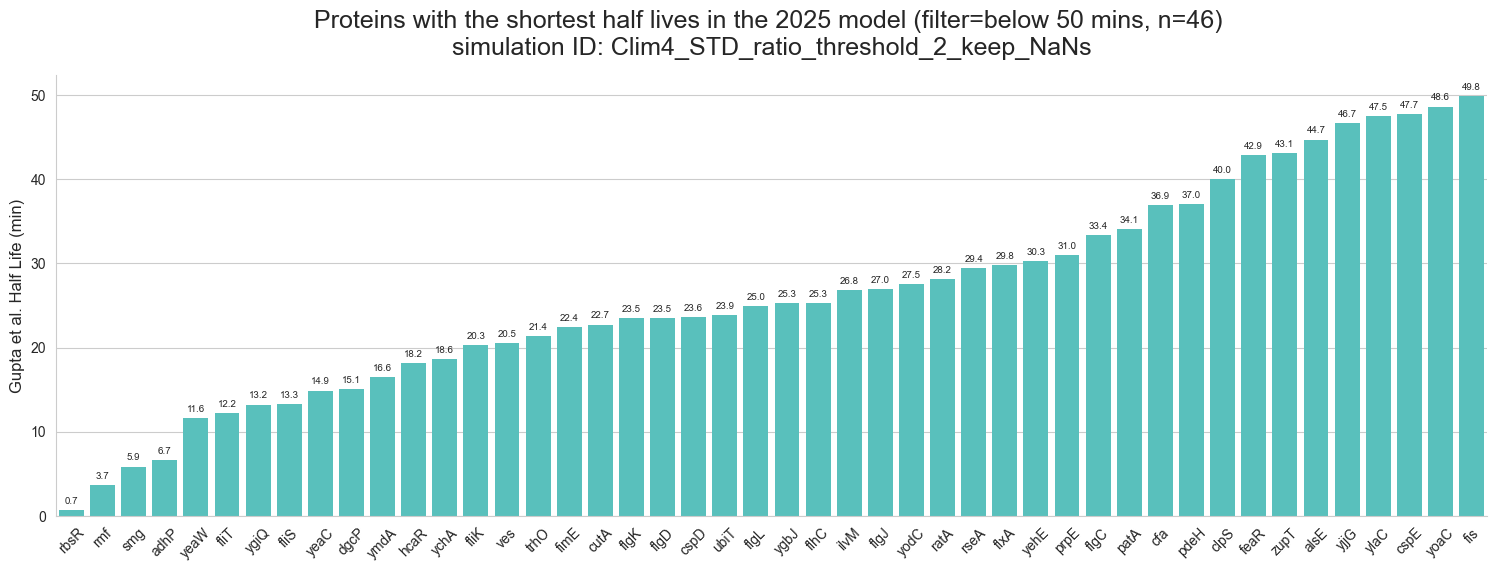

In [108]:
# Plot the proteins with the shortest half lives: 
filter = 50
shortest_proteins = CLNE_CLClimNE_log_data_proteases[(CLNE_CLClimNE_log_data_proteases['half_life_(min)'] < filter) & (CLNE_CLClimNE_log_data_proteases['half_life_source'] == 'Gupta_et_al_MS_2024')]

shortest_proteins = shortest_proteins.sort_values(by="half_life_(min)", ascending=True) 


title = (f"Proteins with the shortest half lives in the 2025 model (filter=below {50} mins, n={str(len(shortest_proteins))}) \nsimulation ID: {current_sequence}")


fig, axes = plt.subplots(figsize=(15,5),  nrows=1, )
fig.tight_layout()


sns.barplot(x='common_name', y='half_life_(min)', data=shortest_proteins, dodge=False, edgecolor='none', color='mediumturquoise')
plt.xticks(rotation=45)
plt.title(title, fontsize=18, pad=15, )
plt.ylabel('Gupta et al. Half Life (min)', fontsize=12, )
plt.xlabel('')

# add values to the bars:
for i, val in enumerate(shortest_proteins['half_life_(min)'].values):
    axes.text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )

# remove the top and right spines:
axes.spines[['right', 'top']].set_visible(False) #https://stackoverflow.com/questions/925024/how-can-i-remove-the-top-and-right-axis


# save the figure:
out_pth = f"out/figures/{branch_name}/plots_under_the_donut/{current_sequence}/monomers_with_half_lives_under_{filter}_mins.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

## Plot the protease assignment specific data

In [109]:
# Remove the proteins that were not assigned to a protease in the model:
priority_substrates = CLNE_CLClimNE_log_data_proteases.copy()
priority_substrates = priority_substrates.dropna(subset=['protease_assignment'])

# Keep half life data only:
data_HL = priority_substrates[['common_name', 'half_life_(min)', 'protease_assignment']]
data_HL.set_index('common_name', inplace=True)

# sort the data by the HL value:
data_HL = data_HL.sort_values(by='half_life_(min)', ascending=True)

data_HL

,half_life_(min),protease_assignment
common_name,,
patA,34.101770,ClpP only
rpoS,54.689884,ClpP only
clpA,67.386866,ClpP only
metR,69.022967,Lon only
ribB,90.636544,ClpP only
...,...,...
ligA,2760.932550,"Additive: ClpP, Lon, HslV"
rpoB,2864.320343,ClpP only
dnaB,2931.793064,ClpP only


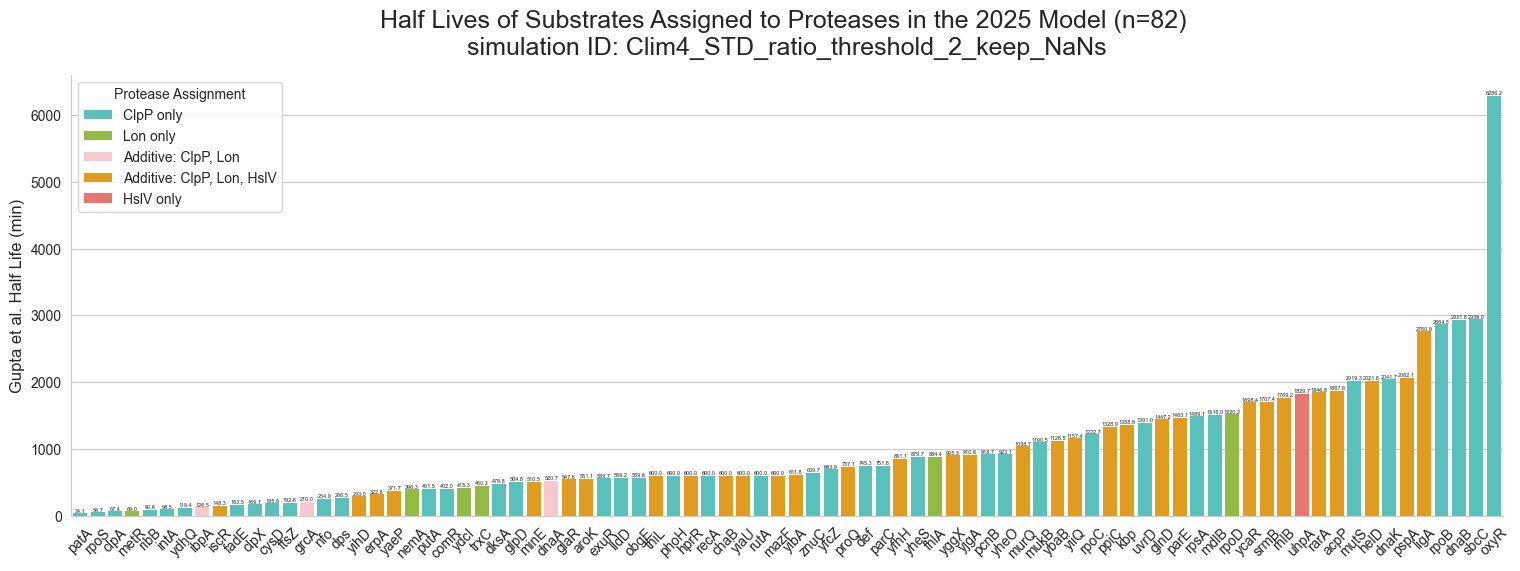

In [110]:
#https://stackoverflow.com/questions/68616781/customizing-the-hue-colors-used-in-seaborn-barplot
#https://stackoverflow.com/questions/72444622/how-to-set-different-colors-on-matplotlib-bar-graph-based-on-the-group-of-data

color_dict = {
    'ClpP only': 'mediumturquoise',
    'Lon only': 'yellowgreen',
    'HslV only': '#fd625e',
    'Additive: ClpP, Lon': 'pink',
    'Additive: ClpP, Lon, HslV': 'orange',
}

title = (f"Half Lives of Substrates Assigned to Proteases in the 2025 Model (n={str(len(data_HL))}) \nsimulation ID: {current_sequence}")
column0 = data_HL['half_life_(min)'].values

fig, axes = plt.subplots(figsize=(15,5),  nrows=1, )
fig.tight_layout()


sns.barplot(x='common_name', y='half_life_(min)', data=data_HL, hue='protease_assignment', palette=color_dict, dodge=False, edgecolor='none')
plt.xticks(rotation=45)
plt.title(title, fontsize=18, pad=15, )
plt.ylabel('Gupta et al. Half Life (min)', fontsize=12, )
plt.xlabel('')
plt.legend(title='Protease Assignment')

# add values to the bars:
for i, val in enumerate(column0):
    axes.text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=4, rotation=0, )

# remove the top and right spines:
axes.spines[['right', 'top']].set_visible(False) #https://stackoverflow.com/questions/925024/how-can-i-remove-the-top-and-right-axis


# save the figure:
out_pth = f"out/figures/{branch_name}/plots_under_the_donut/{current_sequence}/priority_substrate_half_life_bar_graph.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

 Make the same plot as above but order

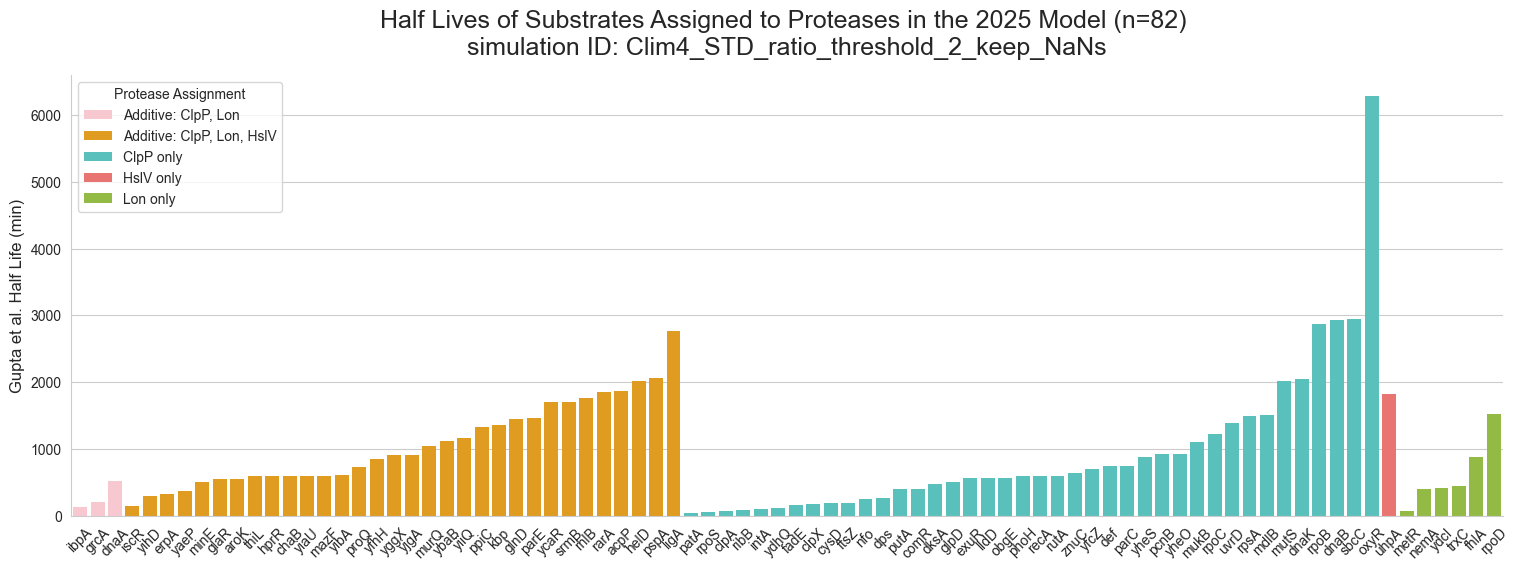

In [111]:
#https://stackoverflow.com/questions/68616781/customizing-the-hue-colors-used-in-seaborn-barplot
#https://stackoverflow.com/questions/72444622/how-to-set-different-colors-on-matplotlib-bar-graph-based-on-the-group-of-data


data_HL_sections = data_HL.sort_values(by=['protease_assignment', 'half_life_(min)'], ascending=[True, True])
# sort the data within the protease assignment by the HL value:

fig, axes = plt.subplots(figsize=(15,5),  nrows=1, )
fig.tight_layout()

title = (f"Half Lives of Substrates Assigned to Proteases in the 2025 Model (n={str(len(data_HL))}) \nsimulation ID: {current_sequence}")

sns.barplot(x='common_name', y='half_life_(min)', data=data_HL_sections, hue='protease_assignment', palette=color_dict, dodge=False, edgecolor='none')
plt.xticks(rotation=45)
plt.title(title, fontsize=18, pad=15, )
plt.ylabel('Gupta et al. Half Life (min)', fontsize=12, )
plt.xlabel('')
plt.legend(title='Protease Assignment')

# add values to the bars:
#for i, val in enumerate(column0):
    #axes.text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )

# remove the top and right spines:
axes.spines[['right', 'top']].set_visible(False) #https://stackoverflow.com/questions/925024/how-can-i-remove-the-top-and-right-axis


# save the figure:
out_pth =  f"out/figures/{branch_name}/plots_under_the_donut/{current_sequence}/priority_substrate_half_life_bar_graph_ordered.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

In [112]:
# todo: consider adding one that is the new and old average monomer counts together

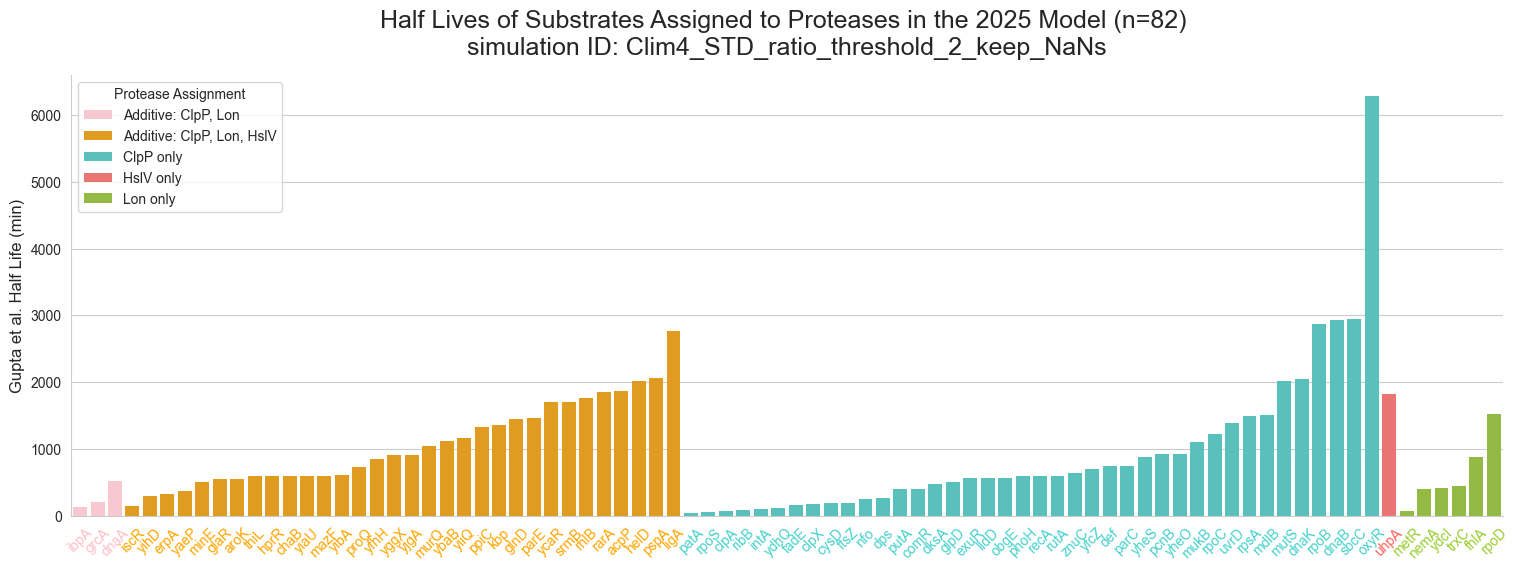

In [113]:
#https://stackoverflow.com/questions/68616781/customizing-the-hue-colors-used-in-seaborn-barplot
#https://stackoverflow.com/questions/72444622/how-to-set-different-colors-on-matplotlib-bar-graph-based-on-the-group-of-data

fig, axes = plt.subplots(figsize=(15,5),  nrows=1, )
fig.tight_layout()

# NOTE: change data to data_HL for the sorted version
sns.barplot(x='common_name', y='half_life_(min)', data=data_HL_sections, hue='protease_assignment', palette=color_dict, dodge=False, edgecolor='none')
plt.xticks(rotation=45)
plt.title(title, fontsize=18, pad=15, )
plt.ylabel('Gupta et al. Half Life (min)', fontsize=12, )
plt.xlabel('')
plt.legend(title='Protease Assignment')

# add values to the bars:
#for i, val in enumerate(column0):
    #axes.text(i, val + 0.5, f"{val:.1f}", ha='center', va='bottom', fontsize=7, rotation=0, )

# remove the top and right spines:
axes.spines[['right', 'top']].set_visible(False) #https://stackoverflow.com/questions/925024/how-can-i-remove-the-top-and-right-axis

# good article: https://stackoverflow.com/questions/42878462/changing-the-color-of-a-single-x-axis-tick-label
for i in range(len(data_HL_sections)):
    name = axes.get_xticklabels()[i].get_text()
    protease_assignment = data_HL_sections.loc[name, 'protease_assignment']
    protease_color = color_dict[protease_assignment]
    plt.setp(axes.get_xticklabels()[i], rotation=45,  color=protease_color)
    
    
# save the figure:
out_pth =  f"out/figures/{branch_name}/plots_under_the_donut/{current_sequence}/priority_substrate_half_life_bar_graph_ordered_and_labels_colored.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it does not exist
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

## protease fraction

In [114]:
# HL data only:
data_PF = priority_substrates[['common_name', 'half_life_(min)', 'protease_assignment', 'ClpP_fraction', 'Lon_fraction', 'HslV_fraction']]


data_PF = data_PF.sort_values(by=['protease_assignment', 'half_life_(min)'], ascending=[True, True])

# calculate the unexplained fraction:
data_PF['Unexplained'] = 1 - (data_PF['ClpP_fraction'] + data_PF['Lon_fraction'] + data_PF['HslV_fraction'])

data_PF.set_index('common_name', inplace=True)
# sort the data by the HL value:
#data_PF = data_PF.sort_values(by='half_life_(min)', ascending=True)


# other data to be used in all plots: 
ClpP = data_PF['ClpP_fraction'].values
Lon = data_PF['Lon_fraction'].values
HslV = data_PF['HslV_fraction'].values
Unexplained = data_PF['Unexplained'].values

# todo: decide how to handle the unexplained data and the redundant/additive data. not sure how to make this look nice. 
compostions1 = {
    'Unexplained': Unexplained,
    'HslV': HslV,
   'Lon': Lon,
    'ClpP': ClpP}

compostions = {
    'HslV': HslV,
   'Lon': Lon,
    'ClpP': ClpP}

protease_color_dict = {
    'ClpP': 'mediumturquoise',
    'Lon': 'yellowgreen',
    'HslV': '#fd625e',
}


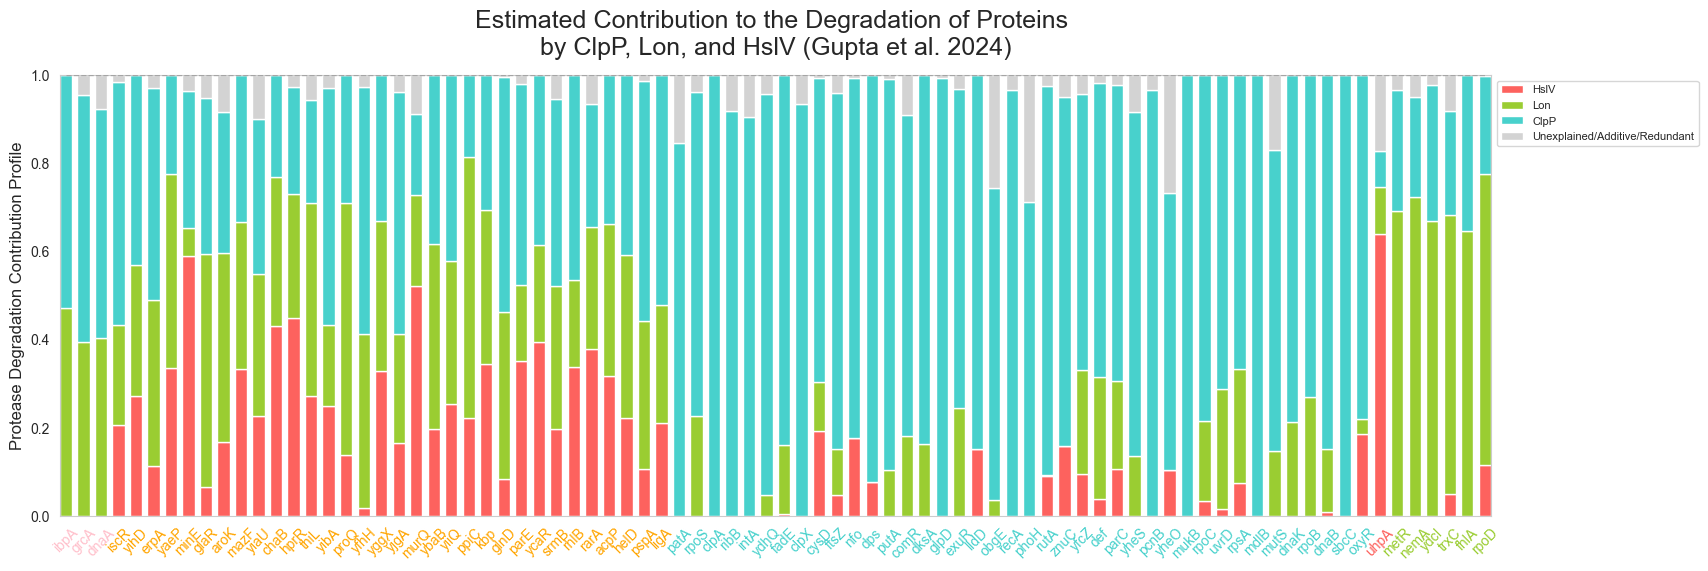

In [115]:
# from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html

fig, ax = plt.subplots(figsize=(15,5),  nrows=1,)
fig.tight_layout()

width = 0.7
names = list(data_PF.index)
bottom = np.zeros(len(data_PF))

# calculate the unexplained + additive + redundant fractions:
UAR = np.zeros(len(data_PF))
for substrate, substrate_count in compostions.items():
    UAR += substrate_count
    
# calculate the unexplained fraction:
UAR = 1 - UAR

compostions2 = {
    'HslV': HslV,
   'Lon': Lon,
    'ClpP': ClpP,
'Unexplained/Additive/Redundant': UAR}

protease_color_dict2 = {
    'ClpP': 'mediumturquoise',
    'Lon': 'yellowgreen',
    'HslV': '#fd625e',
    'Unexplained/Additive/Redundant': 'lightgrey'
}

for substrate, substrate_count in compostions2.items():
    ax.bar(names, substrate_count, width, label=substrate, bottom=bottom, color=protease_color_dict2[substrate],)
    bottom += substrate_count
    #ax.bar_label(p, label_type='center')
    
ax.plot(names,np.ones(len(names)), color='grey', linewidth=1, zorder=5, linestyle='--', alpha=0.5)

ax.set_title('Estimated Contribution to the Degradation of Proteins \nby ClpP, Lon, and HslV (Gupta et al. 2024)', fontsize=18, pad=15, )
plt.tick_params(axis='y', left=False)
plt.xticks(rotation=45)
#ax.yaxis.set_ticks([])
ax.set_ylabel('Protease Degradation Contribution Profile', fontsize=12, )
ax.grid(axis='x', visible=False)
ax.grid(axis='y', visible=False)
ax.margins(x=0.0)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)


# good article: https://stackoverflow.com/questions/42878462/changing-the-color-of-a-single-x-axis-tick-label
for i in range(len(names)):
    name = axes.get_xticklabels()[i].get_text()
    protease_assignment = data_PF.loc[name, 'protease_assignment']
    protease_color = color_dict[protease_assignment]
    plt.setp(ax.get_xticklabels()[i], rotation=45,  color=protease_color)

# save the figure:
out_pth = f"out/figures/{branch_name}/plots_under_the_donut/{current_sequence}/priority_substrate_protease_contribution_bar_graph_labels_colored.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  
plt.savefig(out_pth, dpi=300, bbox_inches='tight')

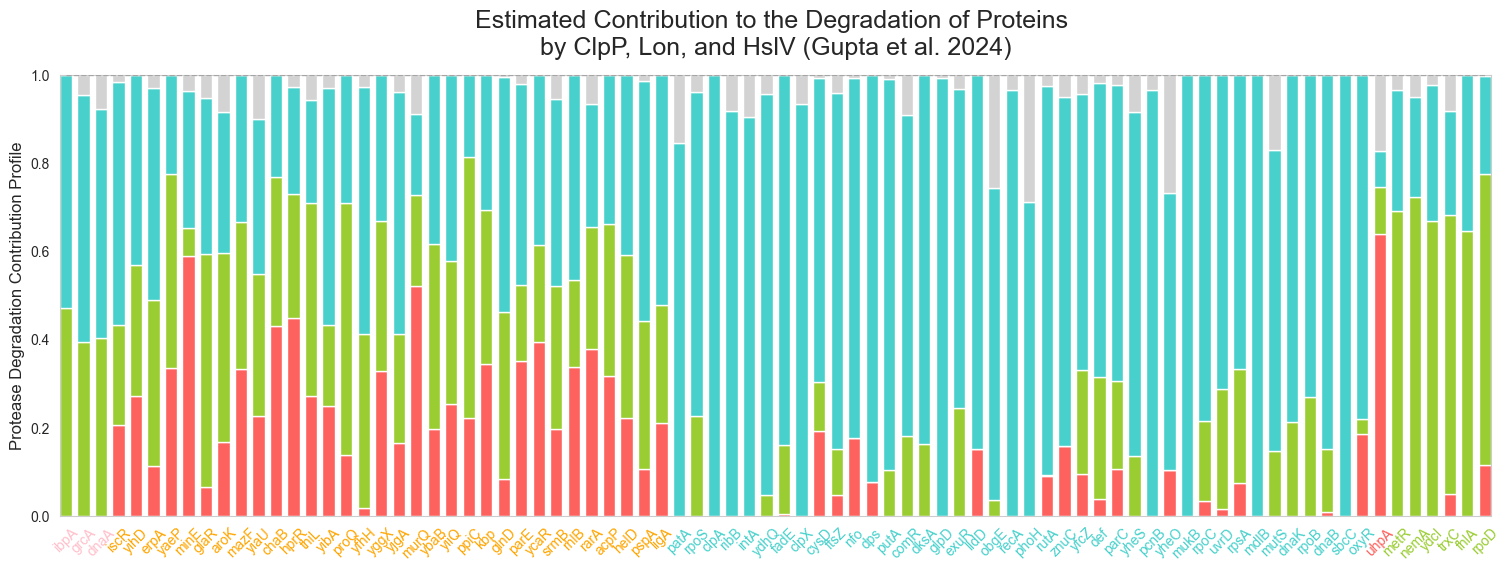

In [116]:
# from: https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_label_demo.html

fig, ax = plt.subplots(figsize=(15,5),  nrows=1,)
fig.tight_layout()

width = 0.7
names = list(data_PF.index)
bottom = np.zeros(len(data_PF))

# calculate the unexplained + additive + redundant fractions:
UAR = np.zeros(len(data_PF))
for substrate, substrate_count in compostions.items():
    UAR += substrate_count
    
# calculate the unexplained fraction:
UAR = 1 - UAR

compostions2 = {
    'HslV': HslV,
   'Lon': Lon,
    'ClpP': ClpP,
'Unexplained/Additive/Redundant': UAR}

protease_color_dict2 = {
    'ClpP': 'mediumturquoise',
    'Lon': 'yellowgreen',
    'HslV': '#fd625e',
    'Unexplained/Additive/Redundant': 'lightgrey'
}

for substrate, substrate_count in compostions2.items():
    ax.bar(names, substrate_count, width, label=substrate, bottom=bottom, color=protease_color_dict2[substrate],)
    bottom += substrate_count
    #ax.bar_label(p, label_type='center')
    
ax.plot(names,np.ones(len(names)), color='grey', linewidth=1, zorder=5, linestyle='--', alpha=0.5)

ax.set_title('Estimated Contribution to the Degradation of Proteins \nby ClpP, Lon, and HslV (Gupta et al. 2024)', fontsize=18, pad=15, )
plt.tick_params(axis='y', left=False)
plt.xticks(rotation=45)
#ax.yaxis.set_ticks([])
ax.set_ylabel('Protease Degradation Contribution Profile', fontsize=12, )
ax.grid(axis='x', visible=False)
ax.grid(axis='y', visible=False)
ax.margins(x=0.0)
#ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)


# good article: https://stackoverflow.com/questions/42878462/changing-the-color-of-a-single-x-axis-tick-label
for i in range(len(names)):
    name = axes.get_xticklabels()[i].get_text()
    protease_assignment = data_PF.loc[name, 'protease_assignment']
    protease_color = color_dict[protease_assignment]
    plt.setp(ax.get_xticklabels()[i], rotation=45,  color=protease_color)

# save the figure:
out_pth = f"out/figures/{branch_name}/plots_under_the_donut/{current_sequence}/priority_substrate_protease_contribution_bar_graph_labels_colored_no_legend.png"
out_pth = os.path.expanduser(out_pth)
output_dir = os.path.dirname(out_pth)
os.makedirs(output_dir, exist_ok=True)  
plt.savefig(out_pth, dpi=300, bbox_inches='tight')
